# Review Classification

## Batching and Model Training

### Import Libraries

In [1]:
import pandas as pd # Loading data
import numpy as np
import warnings 
import re # text matching
from collections import Counter # for vocabulary
from sklearn.model_selection import train_test_split # train test splits

warnings.filterwarnings('ignore')

### Data Loading and Processing

We will first do all the necessary pre-processing before starting to create batches and training the model. All the steps are explained in the notebook named `Text Cleaning.ipynb`

In [2]:
# Read dataset
data = pd.read_csv("Reviews.csv")
# Drop unnecesary columns and duplicates
new_data = data.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'])
# Get useful columns
useful_data = new_data[['Text', 'Score']]
# Calculate length of each sentence without tokenizer
useful_data['sudo_length'] = useful_data.Text.str.split().str.len()
# Filter examples by length
useful_data = useful_data[(useful_data.sudo_length > 20) & (useful_data.sudo_length < 100)]
# Remove length column
useful_data = useful_data.drop(['sudo_length'], axis = 1)
# print 5 rows
useful_data.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Tokenizing and Creating vocabulary
Now its time to tokenize and create our vocabulary. We use the `TextProcessor` class on data splits.

In [3]:
class TextProcessor:
    def __init__(self):
        self.vocab_dict = dict({"<unk>" : 0, "<pad>" : 1})
        self.counter = Counter()

    def tokenize(self, sent):
        if sent.endswith("."):
            sent = sent[:-1]
        new_x = re.sub('<.*?>', ' ', sent)
        new_x = re.sub('\s\s+',' ', new_x)
        new_x = re.sub('\W\s', ' ', new_x)
        new_x = re.sub('\w\W{2,}', ' ', new_x)
        new_x = new_x.lower().split()
        return new_x
        
    def processDataset(self, sent):
        tokens = self.tokenize(sent)
        token_set = set(tokens)
        self.counter.update(Counter(tokens))
        return len(tokens)
        
    def build_vocab(self, num_most_common_to_use=10000):
        words = self.counter.most_common(num_most_common_to_use)
        for i in range(num_most_common_to_use - 2):
            self.vocab_dict[words[i][0]] = len(self.vocab_dict)
            
    def tokenize_and_return_length(self, sent):
        tokens = self.tokenize(sent)
        return len(tokens)
            
    def process(self, sent):
        tokens = self.tokenize(sent)
        processed = []
        for val in tokens:
            processed.append(self.vocab_dict.get(val, self.vocab_dict["<unk>"]))
            
        return processed

#### Create Train and Test sets

In [4]:
train, test = train_test_split(useful_data, test_size = 0.2)

Run text processor to create vocabulary. Also create a new column denoting length of tokens for corresponding review. This will be used in creating batches.

In [5]:
textprocessor = TextProcessor()
train['length'] = train.Text.apply(textprocessor.processDataset)
textprocessor.build_vocab(40000)

train.head()

,Text,Score,length
6476,These cookie bars are great for packing in a l...,5,23
514426,"Hey, its peppercorns, so I don't know what to ...",4,23
29285,This is the second different brand of this typ...,5,33
134660,I was a little worried about these fruits but ...,5,51
512007,This is perhaps the most sophistocated prepare...,5,44


In [6]:
test['length'] = test.Text.apply(textprocessor.tokenize_and_return_length)

test.head()

,Text,Score,length
7606,My puppy loves the stuff. His poo is proper c...,5,45
242127,I noticed that these rawhide chips are very th...,3,74
75777,For a few years now No Fear has been the best ...,5,70
258649,I bought this product to spice up my paninis. ...,5,30
195575,This particular nylabone has lasted longer tha...,5,51


### Batching and Data Loader creation
We are going to use `PyTorch` for training an `LSTM Model` for classification of reviews. Before creating the model, we first need to create dataloader, so that we can conviniently pass our training and testing examples to our model.

First we will create a *Custom PyTorch* dataset class which will preprocess our examples and convert them into a set of indices corresponging to vocabulary we just created.

In [7]:
import torch
from torch.utils.data import Dataset

In [8]:
class ReviewDataset(Dataset):
    def __init__(self, df, processor):
        self.data = df
        self.data = self.data.sort_values(by='length')
        self.tprocess = processor
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row.Text
        label = row.Score
        
        text = self.tprocess.process(text)
        
        return (text, label)

As you can observe that our dataset class sorted our dataframe by the length of each sentence. This allows us to create a batch with minmum padding, as we will see later when creating batches.

In [9]:
train_dataset = ReviewDataset(train, textprocessor)
test_dataset = ReviewDataset(test, textprocessor)

print("Sample Data : ")
print(train_dataset[0])

Sample Data : 
([66, 0, 83, 15061], 5)


### Creating Dataloader

#### Import Dataloader class

In [10]:
from torch.utils.data import DataLoader

#### Custom batch formation class
Since our dataset contains all the examples in sorted fashion, the batch we will get from our dataloader will have the largest length sentence at the end of the batch list. In the batch collator class, we will first create an array or size `(batch_size, seq_len)`, where seq_len will be equal to the length of last sentence recieved in batch.

As all the examples are sorted, padding required within a batch will be minimum as nearly equal length examples will be sampled.

In [11]:
class MyCollator(object):
    def __init__(self, pad_token = 1):
        self.pad = pad_token
    def __call__(self, batch):
        batch_size = len(batch)
        seq_len = len(batch[-1][0])
        formed = np.zeros((batch_size, seq_len), dtype = np.long) + self.pad
        labels = []
        for i in range(batch_size):
            example = batch[i]
            formed[i, :len(example[0])] = example[0]
            labels.append(example[1])
            
        return torch.LongTensor(formed), torch.LongTensor(labels)

In [12]:
BATCH_SIZE = 64

collator = MyCollator()
dloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collator)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collator)

#### Example batch

In [13]:
batch = next(iter(dloader))
print("Examples : ")
print(batch[0])
print("Labels : ")
print(batch[1])

Examples : 
tensor([[  66,    0,   83,  ...,    1,    1,    1],
        [ 464,  789,   29,  ...,    1,    1,    1],
        [   0,  111,  375,  ...,    1,    1,    1],
        ...,
        [ 727,   23,  111,  ...,   13,  120,   39],
        [   3,   15,   83,  ...,   38,    9,  897],
        [   8,  474,   31,  ..., 1206,    3, 3022]])
Labels : 
tensor([5, 5, 5, 5, 5, 4, 5, 4, 5, 1, 5, 5, 5, 5, 5, 1, 1, 4, 1, 3, 5, 5, 5, 5,
        5, 5, 5, 5, 3, 5, 1, 5, 5, 5, 1, 5, 5, 2, 5, 5, 4, 5, 5, 5, 5, 5, 4, 4,
        5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 2])


### Calculating calss weights

In [14]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', sorted(train.Score.unique()), train.Score)
for cat in sorted(train.Score.unique()):
    print("Class {} : {:.5f}".format(cat, weights[cat - 1]))

Class 1 : 2.16999
Class 2 : 4.00186
Class 3 : 2.96125
Class 4 : 1.53882
Class 5 : 0.30287


Now we are ready to start creating our model for Classification!!

### Import Pytorch and other modules

In [15]:
import torch.nn as nn
import torch.optim as opt
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import copy

torch.manual_seed(101)

#### Creating Base Model
The base model is the simplest model we train. It consist of 
- **Embedding layer** : this layer transforms our indexes to 200-D vector that respresent a word.
- **LSTM cell** : the core of our model, the LSTM cell
- **Linear layer** : we take the last output of the lstm layer and use it to predict classes

In [16]:
class BaseModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(BaseModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.cell = nn.LSTM(embedding_dim, hidden_size, batch_first = True)
        self.linear = nn.Linear(hidden_size, num_classes)
        self.soft = nn.Softmax(dim=1)
        
    def forward(self, x, hstate = None):
        if hstate is None:
            hstate = self.init_hidden(self.hidden_size, x.shape[0])
            
        cell_out, _ = self.cell(self.embedding(x), hstate)
        
        out = self.linear(cell_out[:, -1, :])
        
        return self.soft(out)
            
    def init_hidden(self, hidden_size, bs):
        return (torch.zeros(1, bs, hidden_size, device=device), torch.zeros(1, bs, hidden_size, device=device))

#### Creating evalutaion metrics
The evaluation metrics for classification used. Some terms used are,
- **True Positives (TP)**: True positives are the cases when the actual class of the data point was 1(True) and the predicted is also 1(True)
- **True Negatives (TN)**: True negatives are the cases when the actual class of the data point was 0(False) and the predicted is also 0(False
- **False Positives (FP)**: False positives are the cases when the actual class of the data point was 0(False) and the predicted is 1(True). False is because the model has predicted incorrectly and positive because the class predicted was a positive one.(1)
- **False Negatives (FN)**: False negatives are the cases when the actual class of the data point was 1(True) and the predicted is 0(False). False is because the model has predicted incorrectly and negative because the class predicted was a negative one. (0)


The metrics are,
- **Accuracy** : Accuracy in classification problems is the number of correct predictions made by the model over all kinds predictions made.


$$
Accuracy = \frac {Correct prediction}{Total prediction} * 100
$$

- **Precision** : Precision is a measure that tells us what proportion of predictions that we made as belonging to a class, actually belong to that class.


$$
Precision = \frac {TP}{TP + FP}
$$

- **Recall** : Recall is a measure that tells us what proportion of data points that actually belonged to a class were assigned by the algorithm as belonging to that class.


$$
Recall = \frac {TP}{TP + FN}
$$

- **F1 score** : F1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall).


$$
f1  score = 2 * \frac {Precision * Recall}{Precision + Recall}
$$

In [17]:
class ClassificationMetrics:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.classes = list(range(num_classes))
        self.epsilon = 1e-12
        self.cmatrix = np.zeros((num_classes, num_classes), dtype = np.int64) + self.epsilon
        
        self.total_correct = 0
        self.total_examples = 0
        
    def update(self, pred, truth):
        pred = pred.cpu()
        truth = truth.cpu()
        
        _, idx = pred.topk(1)
        truth = truth.view(-1, 1)
        
        self.total_examples += len(truth)
        self.total_correct += sum(idx == truth).item()
        
        val = confusion_matrix(truth, idx, labels=self.classes)
        
        self.cmatrix = self.cmatrix + val
        
        
    def precision_score(self):
        scores = {}
        for i in range(self.num_classes):
            scores[i] = self.cmatrix[i, i] / (sum(self.cmatrix[:, i]) + self.epsilon)
        
        return scores
    
    def recall_score(self):
        scores = {}
        for i in range(self.num_classes):
            scores[i] = self.cmatrix[i, i] / (sum(self.cmatrix[i, :]) + self.epsilon)
        
        return scores
    
    def scores(self, return_type = 'f1'):
        pscores = self.precision_score()
        rscores = self.recall_score()
        scores = {}
        for i in range(self.num_classes):
            if(pscores[i] == 0 and rscores[i] == 0):
                scores[i] = 0
            else:
                scores[i] = 2 * ((pscores[i] * rscores[i]) / (pscores[i] + rscores[i])  + self.epsilon)
            
        if return_type == 'f1':
            return scores
        elif return_type == 'all':
            all_scores = list(zip(pscores.values(), rscores.values(), scores.values()))
            t = {}
            for i in range(self.num_classes):
                t[i] = all_scores[i]
                
            return t
        else:
            raise Exception("Invalid argument for return type")
            
    def accuracy_score(self):
        return self.total_correct / self.total_examples
    
    def reset(self):
        self.total_correct = 0
        self.total_examples = 0
        self.cmatrix = np.zeros((self.num_classes, self.num_classes))
            
    def print_report(self):
        all_scores = self.scores('all')
        print("{:^15}\t{:^15}\t{:^15}\t{:^15}".format("Class", "Precision", "Recall", "F1-score"))
        for c, values in all_scores.items():
            print("{:^15}\t{:^15.3f}\t{:^15.3f}\t{:^15.3f}".format(c, values[0], values[1], values[2]))
            
        print("Accuracy : {:.5f} %".format(self.accuracy_score()))

Creating necessary variables along with our BaseModel, loss function and optimizer.

In [18]:
VOCAB_SIZE = len(textprocessor.vocab_dict)
HIDDEN_SIZE = 128
EMB_DIM = 200
NUM_CLASSES = 5
device = 'cuda'

net = BaseModel(VOCAB_SIZE, EMB_DIM, HIDDEN_SIZE, NUM_CLASSES)
net = net.cuda()
print(net)

metrics = ClassificationMetrics(NUM_CLASSES)
test_metrics = ClassificationMetrics(NUM_CLASSES)

criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights).to(device))
optim = opt.Adam(net.parameters(), lr = 0.001)

BaseModel(
  (embedding): Embedding(40000, 200)
  (cell): LSTM(200, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=5, bias=True)
  (soft): Softmax(dim=1)
)


#### Training loop

In [19]:
N_EPOCHS = 20

pltloss = []
pltacc = []

pltloss_test = []
pltacc_test = []

best_val_acc = 0
best_model = copy.deepcopy(net)

for epoch in range(N_EPOCHS):
    losses = []
    net.train()
    print("Training Loop")
    for batch in tqdm(dloader):
        metrics.reset()
        optim.zero_grad()

        X, labels = batch[0].to(device), (batch[1] - 1).to(device)
        pred = net(X)
        loss = criterion(pred, labels)
        losses.append(loss.item())
        loss.backward()
        optim.step()
        metrics.update(pred, labels)
        
    print("Training Run\nEpoch : {} Loss : {:.5f}".format(epoch + 1, sum(losses) / len(losses)))
    metrics.print_report()
    pltloss.append(sum(losses) / len(losses))
    pltacc.append(metrics.accuracy_score() * 100)
    
    test_losses = []
    net.eval()
    print("Validation Loop")
    for batch in tqdm(test_loader):
        test_metrics.reset()

        X, labels = batch[0].to(device), (batch[1] - 1).to(device)
        pred = net(X)
        loss = criterion(pred, labels)
        test_losses.append(loss.item())
        
        test_metrics.update(pred, labels)
        
    print("Validation Run\nEpoch : {} Loss : {:.5f}".format(epoch + 1, sum(test_losses) / len(test_losses)))
    test_metrics.print_report()
    pltloss_test.append(sum(test_losses) / len(test_losses))
    pltacc_test.append(test_metrics.accuracy_score() * 100)
    
    if((test_metrics.accuracy_score() * 100) > best_val_acc):
        best_val_acc = test_metrics.accuracy_score() * 100
        best_model = copy.deepcopy(net)

  0%|                                                                                         | 0/3506 [00:00<?, ?it/s]

Training Loop


  0%|▎                                                                                 | 4/877 [00:00<00:25, 33.99it/s]

Training Run
Epoch : 1 Loss : 1.45367
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.167     	     0.333     	     0.222     
       4       	     1.000     	     0.600     	     0.750     
Accuracy : 0.45833 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:15, 25.93it/s]

Validation Run
Epoch : 1 Loss : 1.41917
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.500     	     0.500     	     0.500     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     0.923     	     0.667     	     0.774     
Accuracy : 0.59091 %
Training Loop


  0%|▎                                                                                 | 4/877 [00:00<00:25, 34.58it/s]

Training Run
Epoch : 2 Loss : 1.37681
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.250     	     0.500     	     0.333     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.125     	     0.333     	     0.182     
       4       	     0.889     	     0.533     	     0.667     
Accuracy : 0.41667 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:02, 28.65it/s]

Validation Run
Epoch : 2 Loss : 1.38232
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     0.933     	     0.778     	     0.848     
Accuracy : 0.68182 %
Training Loop


  1%|▍                                                                                 | 5/877 [00:00<00:18, 46.85it/s]

Training Run
Epoch : 3 Loss : 1.33316
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.250     	     0.333     	     0.286     
       4       	     0.909     	     0.667     	     0.769     
Accuracy : 0.50000 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:16, 25.71it/s]

Validation Run
Epoch : 3 Loss : 1.38005
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     0.923     	     0.667     	     0.774     
Accuracy : 0.59091 %
Training Loop


  0%|▎                                                                                 | 3/877 [00:00<00:38, 22.79it/s]

Training Run
Epoch : 4 Loss : 1.29382
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.500     	     0.500     	     0.500     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.143     	     0.333     	     0.200     
       4       	     1.000     	     0.733     	     0.846     
Accuracy : 0.54167 %
Validation Loop


  0%|                                                                                 | 2/3506 [00:00<02:58, 19.66it/s]

Validation Run
Epoch : 4 Loss : 1.37045
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     0.929     	     0.722     	     0.813     
Accuracy : 0.63636 %
Training Loop


  0%|▎                                                                                 | 4/877 [00:00<00:25, 33.70it/s]

Training Run
Epoch : 5 Loss : 1.26154
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.500     	     0.500     	     0.500     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.667     	     0.667     	     0.667     
       3       	     0.500     	     0.333     	     0.400     
       4       	     1.000     	     0.933     	     0.966     
Accuracy : 0.75000 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:48, 20.75it/s]

Validation Run
Epoch : 5 Loss : 1.36951
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     0.933     	     0.778     	     0.848     
Accuracy : 0.68182 %
Training Loop


  0%|▎                                                                                 | 4/877 [00:00<00:23, 37.14it/s]

Training Run
Epoch : 6 Loss : 1.23167
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.250     	     0.500     	     0.333     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.500     	     0.333     	     0.400     
       3       	     0.250     	     0.333     	     0.286     
       4       	     1.000     	     0.733     	     0.846     
Accuracy : 0.58333 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:16, 25.71it/s]

Validation Run
Epoch : 6 Loss : 1.36482
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.722     	     0.839     
Accuracy : 0.63636 %
Training Loop


  0%|▎                                                                                 | 4/877 [00:00<00:23, 37.48it/s]

Training Run
Epoch : 7 Loss : 1.20949
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.500     	     0.333     	     0.400     
       3       	     0.500     	     0.333     	     0.400     
       4       	     1.000     	     0.933     	     0.966     
Accuracy : 0.70833 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:03, 28.38it/s]

Validation Run
Epoch : 7 Loss : 1.36941
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.778     	     0.875     
Accuracy : 0.68182 %
Training Loop


  1%|▉                                                                                | 10/877 [00:00<00:17, 49.30it/s]

Training Run
Epoch : 8 Loss : 1.19138
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.667     	     0.667     	     0.667     
       3       	     0.333     	     0.333     	     0.333     
       4       	     1.000     	     0.800     	     0.889     
Accuracy : 0.66667 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:41, 21.64it/s]

Validation Run
Epoch : 8 Loss : 1.36728
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.722     	     0.839     
Accuracy : 0.63636 %
Training Loop


  1%|▍                                                                                 | 5/877 [00:00<00:18, 48.20it/s]

Training Run
Epoch : 9 Loss : 1.17708
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.500     	     0.500     	     0.500     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.500     	     0.667     	     0.571     
       3       	     0.500     	     0.333     	     0.400     
       4       	     1.000     	     0.933     	     0.966     
Accuracy : 0.75000 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:17, 25.49it/s]

Validation Run
Epoch : 9 Loss : 1.36979
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.500     	     0.500     	     0.500     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.667     	     0.800     
Accuracy : 0.59091 %
Training Loop


  1%|▍                                                                                 | 5/877 [00:00<00:19, 44.76it/s]

Training Run
Epoch : 10 Loss : 1.16397
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.500     	     0.500     	     0.500     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.667     	     0.667     	     0.667     
       3       	     0.333     	     0.333     	     0.333     
       4       	     1.000     	     0.867     	     0.929     
Accuracy : 0.70833 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:31, 23.14it/s]

Validation Run
Epoch : 10 Loss : 1.37148
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.722     	     0.839     
Accuracy : 0.63636 %
Training Loop


  1%|▍                                                                                 | 5/877 [00:00<00:19, 44.37it/s]

Training Run
Epoch : 11 Loss : 1.15393
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.500     	     0.500     	     0.500     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.667     	     0.667     	     0.667     
       3       	     0.250     	     0.333     	     0.286     
       4       	     1.000     	     0.800     	     0.889     
Accuracy : 0.66667 %
Validation Loop


  0%|                                                                                 | 2/3506 [00:00<03:17, 17.75it/s]

Validation Run
Epoch : 11 Loss : 1.36987
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.500     	     0.500     	     0.500     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.200     	     1.000     	     0.333     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.722     	     0.839     
Accuracy : 0.68182 %
Training Loop


  1%|▍                                                                                 | 5/877 [00:00<00:20, 42.85it/s]

Training Run
Epoch : 12 Loss : 1.14577
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.500     	     0.500     	     0.500     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.500     	     0.667     	     0.571     
       3       	     0.333     	     0.333     	     0.333     
       4       	     1.000     	     0.867     	     0.929     
Accuracy : 0.70833 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:06, 27.60it/s]

Validation Run
Epoch : 12 Loss : 1.37073
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.722     	     0.839     
Accuracy : 0.63636 %
Training Loop


  1%|▍                                                                                 | 5/877 [00:00<00:20, 43.22it/s]

Training Run
Epoch : 13 Loss : 1.13821
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.500     	     0.500     	     0.500     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.667     	     0.667     	     0.667     
       3       	     0.333     	     0.333     	     0.333     
       4       	     1.000     	     0.867     	     0.929     
Accuracy : 0.70833 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:24, 24.26it/s]

Validation Run
Epoch : 13 Loss : 1.37227
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.667     	     0.800     
Accuracy : 0.59091 %
Training Loop


  1%|▍                                                                                 | 5/877 [00:00<00:20, 42.85it/s]

Training Run
Epoch : 14 Loss : 1.13096
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.500     	     0.667     	     0.571     
       3       	     1.000     	     0.333     	     0.500     
       4       	     1.000     	     1.000     	     1.000     
Accuracy : 0.79167 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:23, 24.46it/s]

Validation Run
Epoch : 14 Loss : 1.37744
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.778     	     0.875     
Accuracy : 0.68182 %
Training Loop


  1%|▍                                                                                 | 5/877 [00:00<00:17, 49.15it/s]

Training Run
Epoch : 15 Loss : 1.12505
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     1.000     	     0.500     	     0.667     
       1       	     0.500     	     1.000     	     0.667     
       2       	     0.400     	     0.667     	     0.500     
       3       	     0.333     	     0.333     	     0.333     
       4       	     1.000     	     0.867     	     0.929     
Accuracy : 0.75000 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:17, 25.49it/s]

Validation Run
Epoch : 15 Loss : 1.37963
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.667     	     0.800     
Accuracy : 0.59091 %
Training Loop


  1%|▍                                                                                 | 5/877 [00:00<00:19, 45.58it/s]

Training Run
Epoch : 16 Loss : 1.12153
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     1.000     	     0.500     	     0.667     
       1       	     0.333     	     1.000     	     0.500     
       2       	     0.500     	     0.667     	     0.571     
       3       	     0.500     	     0.333     	     0.400     
       4       	     1.000     	     0.933     	     0.966     
Accuracy : 0.79167 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:23, 24.46it/s]

Validation Run
Epoch : 16 Loss : 1.37696
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.778     	     0.875     
Accuracy : 0.68182 %
Training Loop


  1%|▍                                                                                 | 5/877 [00:00<00:18, 46.42it/s]

Training Run
Epoch : 17 Loss : 1.11678
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     1.000     	     0.500     	     0.667     
       1       	     0.333     	     1.000     	     0.500     
       2       	     0.500     	     0.667     	     0.571     
       3       	     0.500     	     0.333     	     0.400     
       4       	     1.000     	     0.933     	     0.966     
Accuracy : 0.79167 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:18, 25.28it/s]

Validation Run
Epoch : 17 Loss : 1.37909
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.778     	     0.875     
Accuracy : 0.68182 %
Training Loop


  0%|▎                                                                                 | 4/877 [00:00<00:22, 38.20it/s]

Training Run
Epoch : 18 Loss : 1.11123
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     1.000     	     0.500     	     0.667     
       1       	     0.250     	     1.000     	     0.400     
       2       	     0.667     	     0.667     	     0.667     
       3       	     1.000     	     0.333     	     0.500     
       4       	     1.000     	     1.000     	     1.000     
Accuracy : 0.83333 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:18, 25.28it/s]

Validation Run
Epoch : 18 Loss : 1.37520
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.778     	     0.875     
Accuracy : 0.68182 %
Training Loop


  0%|▎                                                                                 | 4/877 [00:00<00:24, 35.18it/s]

Training Run
Epoch : 19 Loss : 1.10605
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.500     	     0.500     	     0.500     
       1       	     0.500     	     1.000     	     0.667     
       2       	     0.500     	     0.667     	     0.571     
       3       	     1.000     	     0.333     	     0.500     
       4       	     1.000     	     1.000     	     1.000     
Accuracy : 0.83333 %
Validation Loop


  0%|                                                                                 | 3/3506 [00:00<02:09, 27.10it/s]

Validation Run
Epoch : 19 Loss : 1.37737
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.722     	     0.839     
Accuracy : 0.63636 %
Training Loop


  0%|▎                                                                                 | 4/877 [00:00<00:24, 35.18it/s]

Training Run
Epoch : 20 Loss : 1.10427
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.500     	     0.500     	     0.500     
       1       	     0.333     	     1.000     	     0.500     
       2       	     0.500     	     0.667     	     0.571     
       3       	     1.000     	     0.333     	     0.500     
       4       	     1.000     	     0.933     	     0.966     
Accuracy : 0.79167 %
Validation Loop


100%|████████████████████████████████████████████████████████████████████████████████| 877/877 [00:24<00:00, 35.83it/s]

Validation Run
Epoch : 20 Loss : 1.37906
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.333     	     0.500     	     0.400     
       1       	     0.000     	     0.000     	     0.000     
       2       	     0.000     	     0.000     	     0.000     
       3       	     0.000     	     0.000     	     0.000     
       4       	     1.000     	     0.778     	     0.875     
Accuracy : 0.68182 %


In [20]:
print("Best Validation Acuuarcy : {:.3f}%".format(best_val_acc))

Best Validation Acuuarcy : 68.182%


### Ploting loss curve

Text(0.5, 1.0, 'Loss Curves')

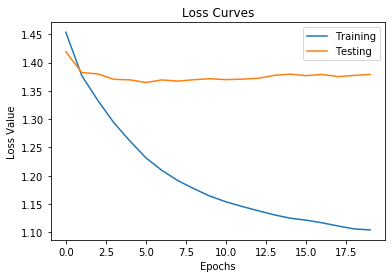

In [21]:
plt.plot(list(range(len(pltloss))), pltloss, label="Training")
plt.plot(list(range(len(pltloss_test))), pltloss_test, label = "Testing")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title("Loss Curves")

### Ploting Accuracy curve

Text(0.5, 1.0, 'Accuracy Value')

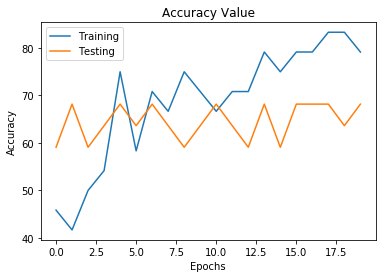

In [22]:
plt.plot(list(range(len(pltacc))), pltacc, label = "Training")
plt.plot(list(range(len(pltacc_test))), pltacc_test, label = "Testing")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Value")

So, we got best validation accuracy of *68.182%*. As we can see from the classification metrics report, our model is just spitting out either class 0 or class 4 for each of our testing examples. The loss is decreases as the epochs progress as well as the accuracy for the Training examples.

## What we will do next?
Next, we are going to use a prebuild library for our text preprocessing along with pretrained embeddings for the words.